In [1]:
# import sframe                                                  
import numpy as np         
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal                    
import copy                                                  
from PIL import Image
from io import BytesIO

# Imagine having these random datapoints generated by 3 Normal distributions A, B, and C

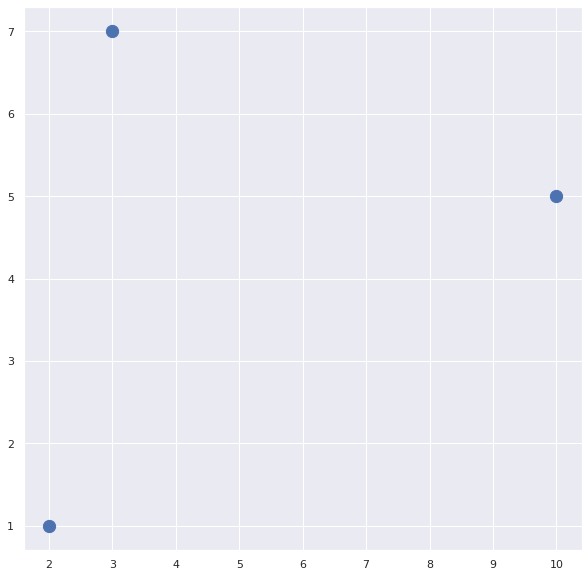

In [2]:
data = np.array([[10.0, 5.0], [2.0, 1], [3, 7]])
data = pd.DataFrame(data, columns = ['x', 'y'])
sns.set(rc={'figure.figsize':(10,10)})
plt.scatter(data.x, data.y, s = 150)
plt.show()

## Initialize some centroids at random

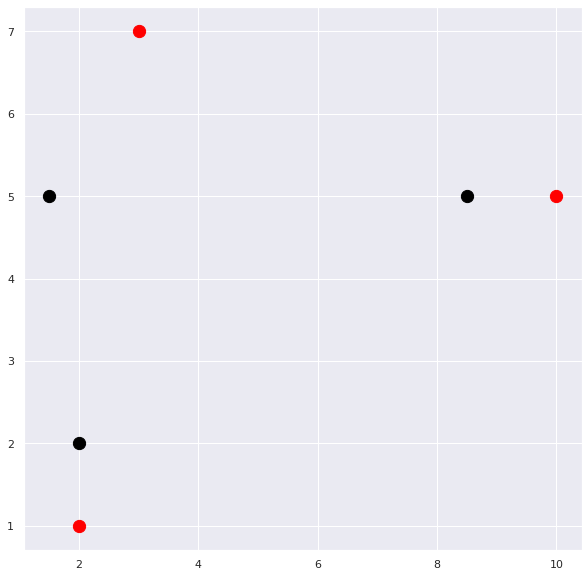

In [3]:
mean_a = np.array([8.5, 5.0])
mean_b = np.array([2, 2])
mean_c = np.array([1.5, 5.0])
centroids = [mean_a, mean_b, mean_c]
centroids = pd.DataFrame(centroids, columns = ['x', 'y'])
plt.scatter(data.x, data.y, s = 150, c = 'red')
plt.scatter(centroids.x, centroids.y, s = 150, c = 'black')
plt.show()

### 📏 next we compute the euclidean distances of all datapoints from the centroids just like kmeans 📏

In [4]:
clusters = ['A', 'B', 'C']

In [5]:
data['A'] = np.sqrt((data.x - centroids.iloc[0].x)**2 + (data.y - centroids.iloc[0].y)**2)
data['B'] = np.sqrt((data.x - centroids.iloc[1].x)**2 + (data.y - centroids.iloc[1].y)**2)
data['C'] = np.sqrt((data.x - centroids.iloc[2].x)**2 + (data.y - centroids.iloc[2].y)**2)

### Now we try hard assignments
In hard assignments each datapoint gets assigned exactly one centroid, even if it likes several centroids, we are being "hard" and make it decide!

In [6]:
#idxmin is a neat pandas function that gives you the min index along an axis, idxmax is its counterpart, wasn't in my pd np cheatsheet
data['Cluster'] = data[['A', 'B', 'C']].idxmin(axis=1)
data

,x,y,A,B,C,Cluster
0,10.0,5.0,1.500000,8.544004,8.500000,A
1,2.0,1.0,7.632169,1.000000,4.031129,B
2,3.0,7.0,5.852350,5.099020,2.500000,C


## Hard Assignments are boring, lets let our datapoints be a bit promiscous 😘

resp here stands for responsibilities, they are the soft assignments and also where the "expectation" in expectation maximization comes from. 

You can think of resp_ij as E[Zij] the fraction of times we'd see x_i from cluster j from all occurances of x_i.

I.e. what is the expected occurence of x_i from cluster j? 
Well simple! p(x_i | cluster = j) / (total p of x_i)

As a motivating example of why you'd want soft-assignments, imagine we're clustering students heights at ETH Zurich and we define two clusters, foreign students and students from switzerland.
Maybe the mean height of students from switzerland is 1.85 and that of foreign students is 1.7. So if you'd see a student with height 1.95 you'd think they're more likely to come from switzerland, but you can not completely rule out that they're foreign either.

In [7]:
# we create a new dataframe so as not to change the above to compare later
resp = data.copy()

### Initialize Clusters at random

In [8]:
#initialize covariance matrix with variance 3 (random) and covariance 0, doesn't have to be this way it just simulates randomness and makes it easier to illustrate
#when we initialize the off-diagonals as 0 we basically say that our clusters are perfect circles with radius rand_init
rand_init = 3.0
cov_init = np.array([[rand_init, 0.0],
                     [0.0, rand_init]])

#these are the normal distributions we initialize with mean defined as their center and covariance matrix above
cluster_a = multivariate_normal(mean = centroids.iloc[0], cov = cov_init)
cluster_b = multivariate_normal(mean = centroids.iloc[1], cov = cov_init)
cluster_c = multivariate_normal(mean = centroids.iloc[2], cov = cov_init)

## Play around with the cluster parameters to see how they shape up get a bit of a feel of the covariance matrix and its meanings

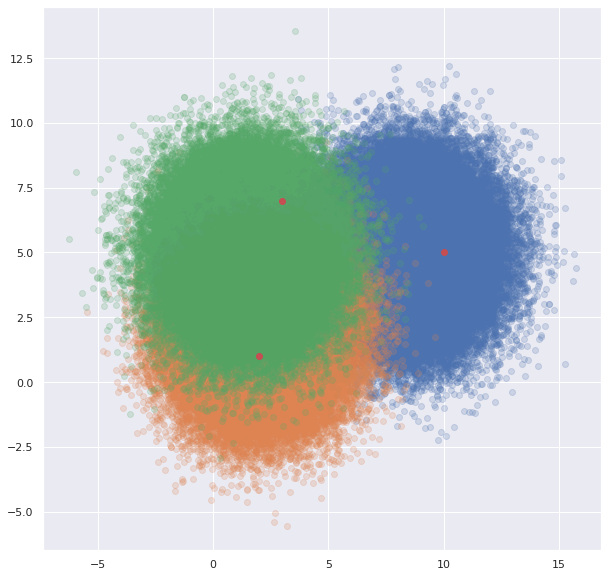

In [9]:
samples = cluster_a.rvs(size = 100000)
samples_b =cluster_b.rvs(size = 100000)
samples_c =cluster_c.rvs(size = 100000)
plt.scatter(samples[:, 0], samples[:, 1], alpha = 0.2)
plt.scatter(samples_b[:, 0], samples_b[:, 1], alpha = 0.2)
plt.scatter(samples_c[:, 0], samples_c[:, 1], alpha = 0.2)
plt.scatter(data.x, data.y)
sns.set(rc={'figure.figsize':(10,10)})
plt.show()

### Now the responsibility A can take for some point x_i is p(z_i = k | parameters of cluster k, observation of x_i) = p(any point being from cluster k)P(x_i | cluster k)
### this translate to prior * likelihood
Since we have obviously no clue in the beginning we just use the most naive prior there is, the uniform prior (which is often a good starting point), i.e. p(any point being from cluster k) = (1 / #clusters) which you can also think of all clusters having equal "weight".
In our case P(x_i | cluster k) is a pdf, it doesn't have to be though.

In [10]:
uniform_prior = 1 / 3.0
#likelihood * prior 
resp['A'] = cluster_a.pdf(data[['x','y']])*uniform_prior
resp['B'] = cluster_b.pdf(data[['x','y']])*uniform_prior
resp['C'] = cluster_c.pdf(data[['x','y']])*uniform_prior

You might notice that bayes theorem is not complete yet and we need to normalize.

In [11]:
# prior*likelihood divided by normalizer = posterior, the normalizer can also be thought of p(seeing the data)
#without this step our weights wouldn't be probabilities since they would not add to 1
normalizer = resp[['A', 'B', 'C']].sum(axis=1).to_numpy()

In [12]:
resp['A'] = resp['A'] / normalizer
resp['B'] = resp['B'] / normalizer
resp['C'] = resp['C'] / normalizer

In [13]:
resp

,x,y,A,B,C,Cluster
0,10.0,5.0,0.999984,0.000008,0.000009,A
1,2.0,1.0,0.000067,0.926950,0.072983,B
2,3.0,7.0,0.008985,0.035536,0.955479,C


### Woot! Woot! We completed the E-Step, this is really all there is, assign probabilities to each of the datapoints of coming from each cluster.


### Now compare soft assignments with the hard assignments we made earlier. In particular it is interesting to look at data point 3.
### Originally we assigned it cluster C, but with uncertainty and variance taken into account we can see that there is actually a 1 in 4 chance it came from cluster A.

Also note that: 

In [14]:
resp["Total Assignment"] = resp[['A', 'B', 'C']].sum(axis=1)
resp

,x,y,A,B,C,Cluster,Total Assignment
0,10.0,5.0,0.999984,0.000008,0.000009,A,1.0
1,2.0,1.0,0.000067,0.926950,0.072983,B,1.0
2,3.0,7.0,0.008985,0.035536,0.955479,C,1.0


The total assignments equal 1. Which means that each of the datapoints is sure to belong to one of the clusters. We are talking probabilities after all.


And:

In [15]:
print(f"We can simply get the weight for each cluster: \n \n{resp[['A', 'B', 'C']].sum(axis=0)}")

We can simply get the weight for each cluster: 
 
A    1.009035
B    0.962494
C    1.028471
dtype: float64


by summing over all the responsibilities in each cluster. 
Now given the data we have, what would be an educated guess if we'd have a new datapoint J of which we do not know its features yet?


In [16]:
total_observations = resp[['A', 'B', 'C']].sum(axis=0) #often denoted as pi for prior
print(f"if we don't know better estimate with what we've seen, p(J = Cluster_k) = \pi_k = (sum of observations in cluster K) / (sum of all observations) = \n{total_observations / data.shape[0]}\n")
print(f"also note that {np.sum(total_observations)} == n == num observations")
cluster_weights = total_observations / data.shape[0]

if we don't know better estimate with what we've seen, p(J = Cluster_k) = \pi_k = (sum of observations in cluster K) / (sum of all observations) = 
A    0.336345
B    0.320831
C    0.342824
dtype: float64

also note that 3.0 == n == num observations


### Triple Woot! these are our new priors!
This is updating in action, see originally we thought they all had equal chance of belonging to any cluster, but now it seems that Cluster B has more weight and in general we're less likely to see samples from cluster C.

# Ok, now lets get our new parameter estimations for clusters A, B and C
The MLE estimator for \mu of a Gaussian distribution is simply the average of the samples. Our samples are fractions, but that won't stop us.

In [17]:
eps = 0.0001
def get_mus():
    mus = {}
    for cluster in clusters:
        #now we get the weighted average of all points in the cluster = 1/n*(resp*datapoint)
        cluster_mean = np.sum([data.x * resp[cluster], data.y * resp[cluster]], axis=1)
        if total_observations[cluster] < eps:
            cluster_mean /= eps
        else:
            cluster_mean /= total_observations[cluster]
        mus[cluster] = cluster_mean
    return mus

In [18]:
mus = get_mus()

### Means are only half the story, next the variances

In [19]:
datapoints = data[['x', 'y']].to_numpy()

In [20]:
def get_vars():
    variances = {}
    #we use the biased estimator 1/n((x_i - mu_k)*(x_i - mu_k)^T)
    for cluster in clusters:
        cov_matrix = np.zeros_like(cov_init)
        #somehow the @ operator doesn't insert the missing column, I could use expand_dims but I find that less readable than np.outer(a, b) = outer product of a and b
        for datapoint, weight in zip(datapoints, resp[cluster]):
            #distance from mean
            dm = (datapoint - mus[cluster])
            cov_matrix += np.outer(dm, dm)*weight
            if total_observations[cluster] < eps:
                cov_matrix /= eps
            else:
                cov_matrix /= total_observations[cluster]
        variances[cluster] = cov_matrix
    return variances

In [21]:
variances = get_vars()

In [22]:
mus

{'A': array([9.93714118, 5.01754508]),
 'B': array([2.03698366, 1.22155604]),
 'C': array([2.92909529, 6.57420492])}

In [23]:
variances

{'A': array([[ 0.43648115, -0.12144822],
        [-0.12144822,  0.03635031]]),
 'B': array([[0.03614709, 0.21390853],
        [0.21390853, 1.28203737]]),
 'C': array([[0.0646256 , 0.38530196],
        [0.38530196, 2.31236172]])}

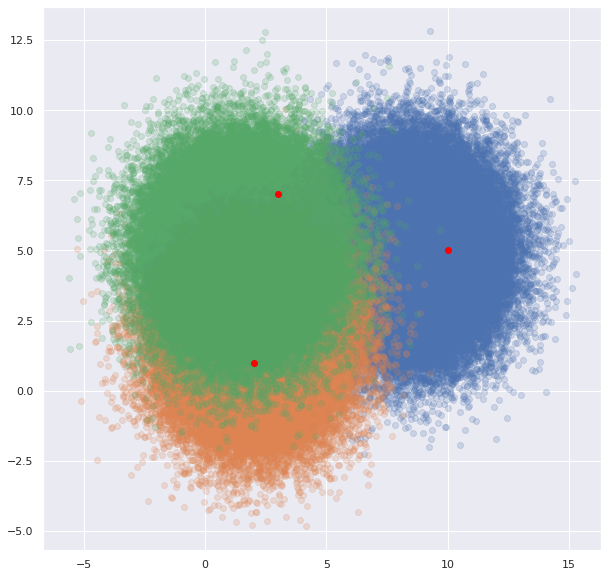

In [24]:
#these are the normal distributions we initialize with mean defined as their center and covariance matrix above
cluster_a = multivariate_normal(mean = centroids.iloc[0], cov = cov_init)
cluster_b = multivariate_normal(mean = centroids.iloc[1], cov = cov_init)
cluster_c = multivariate_normal(mean = centroids.iloc[2], cov = cov_init)
samples = cluster_a.rvs(size = 100000)
samples_b =cluster_b.rvs(size = 100000)
samples_c =cluster_c.rvs(size = 100000)
plt.scatter(samples[:, 0], samples[:, 1], alpha = 0.2)
plt.scatter(samples_b[:, 0], samples_b[:, 1], alpha = 0.2)
plt.scatter(samples_c[:, 0], samples_c[:, 1], alpha = 0.2)
for datapoint in datapoints:
    plt.scatter(datapoint[0], datapoint[1], color = 'red')
sns.set(rc={'figure.figsize':(10,10)})
plt.show()

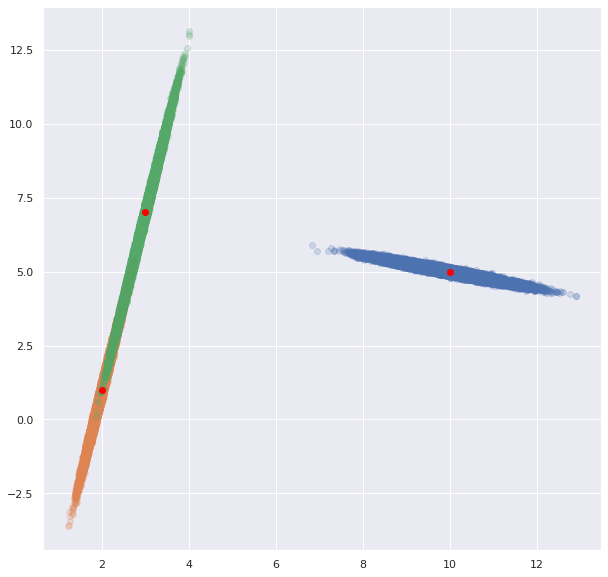

In [25]:
#these are the normal distributions we initialize with mean defined as their center and covariance matrix above
cluster_a = multivariate_normal(mean = mus['A'], cov =  variances['A'], allow_singular = True)
cluster_b = multivariate_normal(mean = mus['B'], cov =  variances['B'], allow_singular = True)
cluster_c = multivariate_normal(mean = mus['C'], cov =  variances['C'], allow_singular = True)
samples = cluster_a.rvs(size = 100000)
samples_b =cluster_b.rvs(size = 100000)
samples_c =cluster_c.rvs(size = 100000)
plt.scatter(samples[:, 0], samples[:, 1], alpha = 0.2)
plt.scatter(samples_b[:, 0], samples_b[:, 1], alpha = 0.2)
plt.scatter(samples_c[:, 0], samples_c[:, 1], alpha = 0.2)
for datapoint in datapoints:
    plt.scatter(datapoint[0], datapoint[1], color = 'red')
sns.set(rc={'figure.figsize':(10,10)})
plt.show()

In [26]:
for i in range(1):
    #E-Step assign datapoints
    #likelihood * prior 
    prior = cluster_weights
    resp['A'] = cluster_a.pdf(data[['x','y']])*cluster_weights['A']
    resp['B'] = cluster_b.pdf(data[['x','y']])*cluster_weights['B']
    resp['C'] = cluster_c.pdf(data[['x','y']])*cluster_weights['C']
    total_observations = resp[['A', 'B', 'C']].sum(axis=0) 
    cluster_weights = total_observations / data.shape[0]
    
    #M-Step optimize the parameters
    variances = get_vars()
    mus = get_mus()
    #these are the normal distributions we initialize with mean defined as their center and covariance matrix above
    cluster_a = multivariate_normal(mean = mus['A'], cov =  variances['A'], allow_singular = True)
    cluster_b = multivariate_normal(mean = mus['B'], cov =  variances['B'], allow_singular = True)
    cluster_c = multivariate_normal(mean = mus['C'], cov =  variances['C'], allow_singular = True)

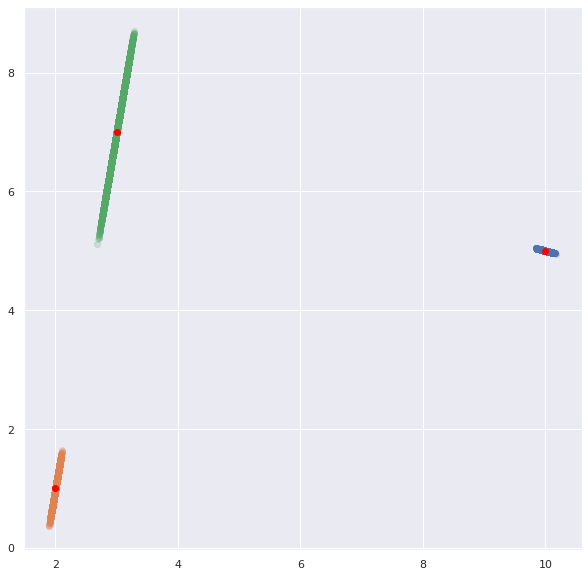

In [27]:
samples = cluster_a.rvs(size = 100000)
samples_b =cluster_b.rvs(size = 100000)
samples_c =cluster_c.rvs(size = 100000)
plt.scatter(samples[:, 0], samples[:, 1], alpha = 0.2)
plt.scatter(samples_b[:, 0], samples_b[:, 1], alpha = 0.2)
plt.scatter(samples_c[:, 0], samples_c[:, 1], alpha = 0.2)
for datapoint in datapoints:
    plt.scatter(datapoint[0], datapoint[1], color = 'red')
sns.set(rc={'figure.figsize':(10,10)})
plt.show()

### Possibly a fun exercise, with lots of data this will likely not work very well because everything is exponential. 
Instead maybe try the log likelihood and play with below example
sklearns implementation is pretty straight forward: https://github.com/scikit-learn/scikit-learn/blob/baf0ea25d/sklearn/mixture/_gaussian_mixture.py#L456
or you know, instead of reinventing the wheel just use it :-) knowing now with confidence that you can compute it by hand if needed

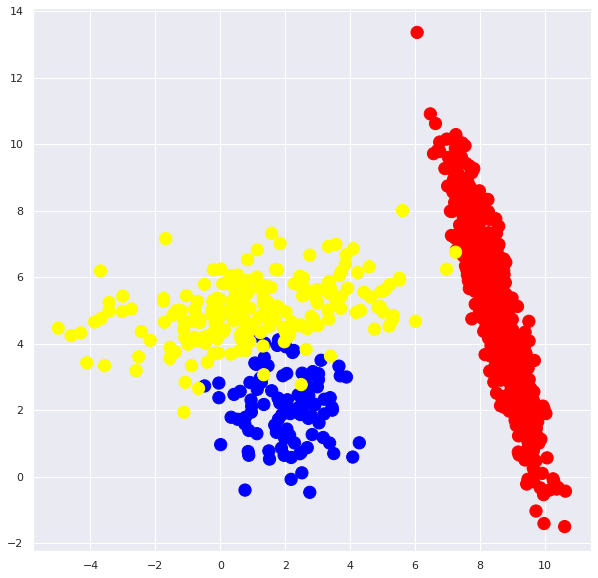

In [28]:
cov_a = np.array([[0.5, -1.5], 
                  [-1.5, 5.5]]) #long
mean_a = np.array([8.5, 5.0])
cov_b = np.array([[1, 0.0], 
                  [0.0, 1.0]]) #circle
mean_b = np.array([2, 2])
cov_c = np.array([[5.5, 0.8], 
                  [0.8, 0.8]]) #wide
mean_c = np.array([1.5, 5.0])


a = multivariate_normal(mean_a, cov_a)
b = multivariate_normal(mean_b, cov_b)
c = multivariate_normal(mean_c, cov_c)
size_a, size_b, size_c = 700, 100, 200
samples_a = a.rvs(size = size_a) #a should get a much higher weight after some time
samples_b =b.rvs(size = size_b)
samples_c =c.rvs(size = size_c)
data = np.concatenate([samples_a, samples_b, samples_c])
# data = np.array([[10.0, 5.0], [2.0, 1], [3, 7], [5, 6], [9, 4], [3, 1], [2, 3], [3, 5], [5, 5]])
# data = np.array([[10.0, 5.0], [2.0, 1], [3, 7]])
data = pd.DataFrame(data, columns = ['x', 'y'])
data['colors'] = ['red' for i in range(size_a)] + ['blue' for i in range(size_b)] + ['yellow' for i in range(size_c)]
sns.set(rc={'figure.figsize':(10,10)})
plt.scatter(data.x, data.y, s = 150, c = data['colors'])
# plt.scatter(data.x, data.y, s = 150)
plt.show()

In [29]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 3, verbose = 1, max_iter = 10) #set max_iter higher or use basian gaussian mixture with unknown number of components
gmm.fit(data[['x', 'y']])

Initialization 0
Initialization converged: True


GaussianMixture(max_iter=10, n_components=3, verbose=1)

In [30]:
data[['A', 'B', 'C']] = np.around(gmm.predict_proba(data[['x', 'y']]), 2)
data

,x,y,colors,A,B,C
0,8.387168,4.431219,red,0.0,0.35,0.65
1,8.498030,3.451953,red,0.0,0.19,0.81
2,8.098307,7.003754,red,0.0,0.84,0.16
3,8.562306,5.510384,red,0.0,0.57,0.43
4,9.286489,3.305866,red,0.0,0.16,0.84
...,...,...,...,...,...,...
995,-1.120369,1.938598,yellow,1.0,0.00,0.00
996,0.669206,5.905818,yellow,1.0,0.00,0.00
997,-1.080812,2.838806,yellow,1.0,0.00,0.00
998,1.238621,4.332857,yellow,1.0,0.00,0.00


In [31]:
gmm.means_

array([[1.39707842, 4.02316654],
       [8.08630605, 6.54406934],
       [8.9038921 , 3.55317954]])

In [32]:
gmm.covariances_

array([[[ 4.16267709, -0.098947  ],
        [-0.098947  ,  2.80667661]],

       [[ 0.33935238, -0.85155576],
        [-0.85155576,  3.11595894]],

       [[ 0.32594874, -0.89241372],
        [-0.89241372,  3.33726262]]])

In [33]:
#priors our cluster weights from before
gmm.weights_

array([0.29875619, 0.34175414, 0.35948967])

# Actually sklearn didn't do so well 🤣
Good reminder that this happens from time to time, it doesn't have to find the global maximum but can converge to a local maximum, EM can easily overfit, to see this look at the normal distributions formula and think about what happens to likelihood N(x | mu, sigma) as sigma -> 0

Most of the times it does quite well though.


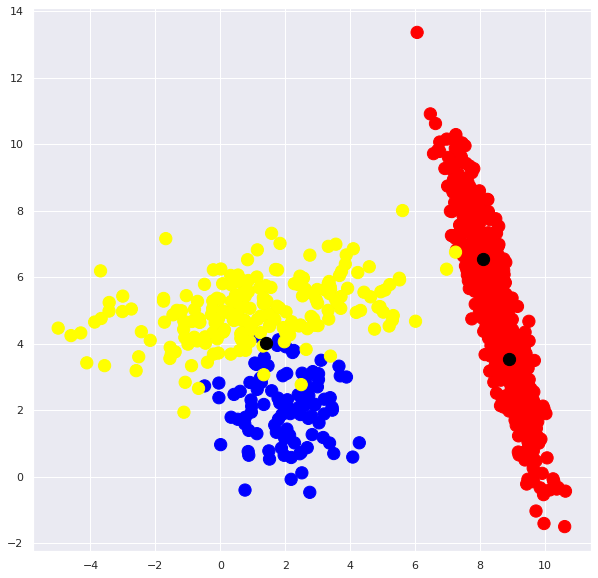

In [34]:
plt.scatter(data.x, data.y, s = 150, c = data['colors'])
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s = 150, color = 'black')
plt.show()